# INM706 Coursework
## Disease Prognosis Prediction using Longitudinal Electronic Health Records and Gated Recurrent Units
### Aaron Mir (Student Number: 160001207)

NOTE: I cannot upload the original MIMIC-III CSV files to GitHub or Moodle as per the privacy agreement. However, the main data extracted from from the CSVs during data preprocessing is be uploaded after being pickled. You can start the code from the Preparation of data, labels section after importing the data.encoded_icd9s file.

MIMIC-III is a large, freely-available database comprising deidentified health-related data associated with over 40,000 patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The MIMIC-III Clinical Database is available on PhysioNet. Though deidentified, MIMIC-III contains detailed information regarding the care of real patients, and as such requires credentialing before access.

My goal is to attempt to predict future ICD9 (diagnosis) codes from patients using a GRU. The model can be found in the Model section and Results can be found in the training and evaluation sections. As we can see, the training and validation losses decrease well. However, we can see the model is overfitting, even with dropout layers etc. I focus on Recall results, but Accuracy, Precision and F1-Score were also computed for the train, test and validation sets. In general, the model achieved a very high recall score and a very low precision score. Since the context of this prediction is biomedical in nature, having a high recall is not necessarily bad since the benefit of a patient being told they may progress in a certain way outweighs the risk of a sudden disease onset with no warning. On the other hand, if the prediction is incorrect, this would cause panic.

Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID.
Each row of this table contains a unique HADM_ID, which represents a single patient’s admission to the hospital. HADM_ID ranges from 1000000 - 1999999. It is possible for this table to have duplicate SUBJECT_ID, indicating that a single patient had multiple admissions to the hospital. The ADMISSIONS table can be linked to the PATIENTS table using SUBJECT_ID.
https://mimic.physionet.org/mimictables/admissions/ - info about admissions table

In [ ]:
##--------------------Coding References---------------------##
# Percentage of borrowed code: 10% - Parts of the GRU model etc. 
# [1] Russell-Puleri, Sparkle (2019) Doctor AI Pytorch Minimal Implementation, Available at:
#  https://github.com/sparalic/Electronic-Health-Records-GRUs/blob/master/DrAI_pytorch.ipynb (Accessed: 14th March 2021).

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
from math import ceil
import random
import sys
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
torch.set_printoptions(edgeitems=10)

## Exploratory Analysis of Data - no CSVs in the data folder for data protection reasons, skip to next Preparation for data, label section
### Admissions Table

In [55]:
admission_data = pd.read_csv('data\\ADMISSIONS.csv')

In [56]:
admission_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


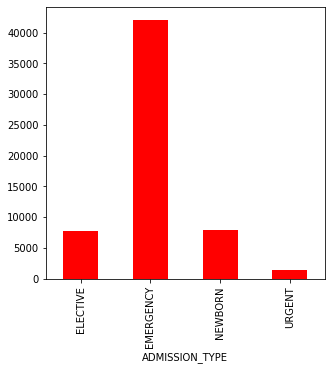

In [57]:
fig = plt.figure(figsize=(5,5))
admission_data.groupby(['ADMISSION_TYPE']).size().plot.bar(color = 'red');

In [4]:
admission_data.ADMITTIME = pd.to_datetime(admission_data.ADMITTIME, format = '%Y-%m-%d %H:%M:%S')           # changing the format of the time in the table
admission_data.DISCHTIME = pd.to_datetime(admission_data.DISCHTIME, format = '%Y-%m-%d %H:%M:%S')
admission_data.DEATHTIME = pd.to_datetime(admission_data.DEATHTIME, format = '%Y-%m-%d %H:%M:%S')

In [5]:
admission_data = admission_data.sort_values(['SUBJECT_ID','ADMITTIME'])          # sorting by subject_id and admission times
admission_data = admission_data.reset_index(drop = True)

In [6]:
admission_data.loc[admission_data.SUBJECT_ID  == 801, ['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE', 'DISCHTIME']]      # looking at an example

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,DISCHTIME
817,801,2197-06-19 19:47:00,EMERGENCY,2197-08-03 13:00:00
818,801,2197-08-09 21:00:00,EMERGENCY,2197-09-15 14:17:00
819,801,2198-07-09 23:22:00,EMERGENCY,2198-07-16 14:06:00


In [6]:
admission_data['NEXT_ADMITTIME'] = admission_data.groupby('SUBJECT_ID').ADMITTIME.shift(-1)             # creating new columns for the next admissions and type of admission for a subject
admission_data['NEXT_ADMISSION_TYPE'] = admission_data.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [8]:
admission_data.loc[admission_data.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE', 'DISCHTIME', 'NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] # continuing with example

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,DISCHTIME,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
817,801,2197-06-19 19:47:00,EMERGENCY,2197-08-03 13:00:00,2197-08-09 21:00:00,EMERGENCY
818,801,2197-08-09 21:00:00,EMERGENCY,2197-09-15 14:17:00,2198-07-09 23:22:00,EMERGENCY
819,801,2198-07-09 23:22:00,EMERGENCY,2198-07-16 14:06:00,NaT,NaN


In [7]:
rows = admission_data.NEXT_ADMISSION_TYPE == 'ELECTIVE'           # if the subject's next admission is elective, then we won't consider this
admission_data.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
admission_data.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [10]:
admission_data.loc[admission_data.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
817,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
818,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
819,801,2198-07-09 23:22:00,EMERGENCY,NaT,NaN


In [8]:
admission_data[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admission_data.groupby(['SUBJECT_ID'])\
[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [13]:
admission_data.loc[admission_data.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
817,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
818,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
819,801,2198-07-09 23:22:00,EMERGENCY,NaT,NaN


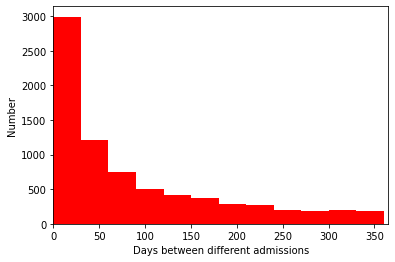

In [12]:
fig = plt.figure() 
admission_data['DAYS_NEXT_ADMIT'] = (admission_data.NEXT_ADMITTIME - admission_data.DISCHTIME).dt.total_seconds()/(24*60*60)
plt.hist(admission_data.loc[~admission_data.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins = range(0,365,30), color = 'red')
plt.xlim([0,365])
plt.xlabel('Days between different admissions')
plt.ylabel('Number')
plt.show()

### Notes Table

In [18]:
notes_data = pd.read_csv('data\\NOTEEVENTS.csv')

C:\Python38\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
notes_data.head() 

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [20]:
print('Number of notes:',len(notes_data))

Number of notes: 2083180


In [21]:
notes_data.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

<AxesSubplot:xlabel='CATEGORY'>

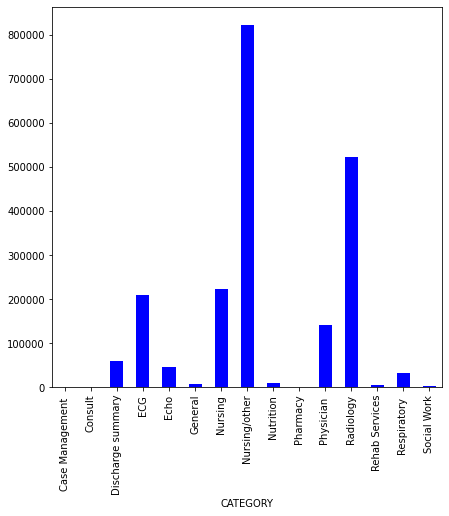

In [26]:
fig = plt.figure(figsize=(7, 7)) 
notes_data.groupby(['CATEGORY']).size().plot.bar(color = 'blue')

### Diagnosis Code Table

In [13]:
diagnosis_code_data = pd.read_csv('data\\DIAGNOSES_ICD.csv')

In [28]:
diagnosis_code_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [29]:
diagnosis_code_data

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280
651043,639799,97503,188195,3.0,V5869
651044,639800,97503,188195,4.0,V1279
651045,639801,97503,188195,5.0,5275


### Diagnosis Table

In [14]:
diagnosis_data = pd.read_csv('data\\D_ICD_DIAGNOSES.csv')

In [25]:
diagnosis_data.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


### Patients Table

In [16]:
patient_data = pd.read_csv('data\\PATIENTS.csv')

In [27]:
patient_data.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [28]:
print(f"Total Patients: {len(patient_data)}")
print(f"Number of Males: {len(patient_data[patient_data['GENDER'] == 'M'])}")
print(f"Number of Females: {len(patient_data[patient_data['GENDER'] == 'F'])}")

Total Patients: 46520
Number of Males: 26121
Number of Females: 20399


C:\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


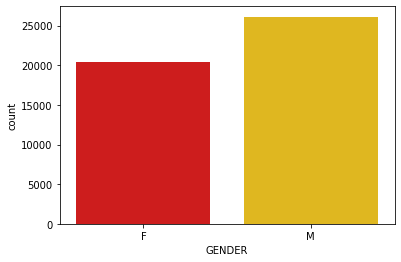

In [29]:
sns.countplot(patient_data['GENDER'], palette="hot")
plt.show()

## Data pre-processing

Checklist

    1. Extract hadm_id, subject_id_ admittime, dischtime, icd9_code
    2. Map the subject_id with the hadm_id and the admittime to match a patient to specific visits
    3. Map the hadm_id to each icd9_code assigned during the visit
    4. Add each code assigned to the patient directing into the dictionary with the patient-admission id mapping and the visit date mapping . Which allows us to have a list of list of icd9_code's that each patient recieved during each visit.

ADMISSIONS: Every unique hospitalisation for each patient in the database (defines HADM_ID)

DIAGNOSES_ICD: Hospital assigned diagnoses, coded using the International Statistical Classification of Diseases and Related Health Problems (ICD) system

D_ICD_DIAGNOSES: Dictionary of International Statistical Classification of Diseases and Related Health Problems (ICD) codes relating to diagnoses

Each HADM_ID corresponds to a single SUBJECT_ID. A single SUBJECT_ID can correspond to multiple HADM_ID (multiple hospitalisations of the same patient), and multiple ICUSTAY_ID (multiple ICU stays either within the same hospitalization, or across multiple hospitalizations, or both).

In [8]:
admission_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,NaN
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,NaN
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,NaN


In [17]:
diagnosis_code_data

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280
651043,639799,97503,188195,3.0,V5869
651044,639800,97503,188195,4.0,V1279
651045,639801,97503,188195,5.0,5275


In [9]:
admission_data[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00
...,...,...,...,...
58971,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00
58972,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00
58973,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00
58974,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00


In [10]:
#reordering admission data so we can put into a suitable format 
admission_data[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']].sort_values(['SUBJECT_ID','HADM_ID']) # ordered based on subject id and hadm_id

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00
...,...,...,...,...
58971,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00
58972,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00
58973,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00
58974,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00


In [11]:
# changing the table name to data
data = admission_data[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']].sort_values(['SUBJECT_ID','HADM_ID'])
data.to_csv('data/ADMISSIONS_shrink.csv')

In [ ]:
# create two dictionaries: one that maps each patient with their specific HADM_ID
#                          another that maps each HADM_ID with the date and time of the admission
subject_hadm_map = {}
hadm_date_map = {}
for subject_id in data.SUBJECT_ID:
    subject_hadm_map[str(subject_id)] = list(map(str, list(data[data['SUBJECT_ID'] == subject_id]['HADM_ID'].values)))
for hadm_id in data.HADM_ID:
    hadm_date_map[str(hadm_id)] = [datetime.strptime(data[data['HADM_ID'] == hadm_id]['ADMITTIME'].values[0], '%Y-%m-%d %H:%M:%S')] # for some reason, when running this loop again, it does not work, returns strptime error

In [148]:
subject_hadm_map['17']

['161087', '194023']

In [149]:
print(hadm_date_map['161087'])
print(hadm_date_map['194023'])

[datetime.datetime(2135, 5, 9, 14, 11)]
[datetime.datetime(2134, 12, 27, 7, 15)]


In [54]:
# reordering diagnosis code data to create the necessary future mappings
diagnosis_code_data[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].sort_values(['SUBJECT_ID','HADM_ID']) # ordered based on subject id and hadm_id

,SUBJECT_ID,HADM_ID,ICD9_CODE
608,2,163353,V3001
609,2,163353,V053
610,2,163353,V290
611,3,145834,0389
612,3,145834,78559
...,...,...,...
648478,99999,113369,75612
648479,99999,113369,7861
648480,99999,113369,4019
648481,99999,113369,25000


In [20]:
diagnosis_code_data = diagnosis_code_data[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].sort_values(['SUBJECT_ID','HADM_ID'])  # putting diagnosis code data into the above format

In [120]:
# create a dictionary that maps each HADM_ID with the specific ICD9 diagnosis codes given during the visit
hadm_icd9_map = {}          
for hadm_id in data.HADM_ID:
    hadm_icd9_map[str(hadm_id)] = list(diagnosis_code_data[diagnosis_code_data['HADM_ID'] == hadm_id]['ICD9_CODE'].values)

In [150]:
print(hadm_icd9_map['161087'])
print(hadm_icd9_map['194023'])

['4239', '5119', '78551', '4589', '311', '7220', '71946', '2724']
['7455', '45829', 'V1259', '2724']


In [151]:
# create a dictionary mapping subject_id to their admittime for each hadm_id and the diagnoses for that admission
subject_admittime_icd9 = {}
for subject_id, admit_time in subject_hadm_map.items():
    ordered_map = ([(hadm_date_map[admittime], hadm_icd9_map[admittime]) for admittime in admittime])
    subject_admittime_icd9[subject_id] = ordered_map

In [153]:
subject_admittime_icd9['17']

[([datetime.datetime(2135, 5, 9, 14, 11)],
  ['4239', '5119', '78551', '4589', '311', '7220', '71946', '2724']),
 ([datetime.datetime(2134, 12, 27, 7, 15)],
  ['7455', '45829', 'V1259', '2724'])]

In [154]:
# extract a list of subject_IDs, admittimes and icd9_codes for encoding
subject_IDs = [subject_id for subject_id, admittime in subject_admittime_icd9.items()]
admit_times_list = [[visit[0][0] for visit in admittime] for subject_id, admittime in subject_admittime_icd9.items()]
icd9_codes_list = [[visit[1] for visit in admittime] for subject_id, admittime in subject_admittime_icd9.items()]

In [156]:
subject_IDs[:5]

['2', '3', '4', '5', '6']

In [157]:
admit_times_list[:5]

[[datetime.datetime(2138, 7, 17, 19, 4)],
 [datetime.datetime(2101, 10, 20, 19, 8)],
 [datetime.datetime(2191, 3, 16, 0, 28)],
 [datetime.datetime(2103, 2, 2, 4, 31)],
 [datetime.datetime(2175, 5, 30, 7, 15)]]

In [158]:
icd9_codes_list[:5]

[[['V3001', 'V053', 'V290']],
 [['0389', '78559', '5849', '4275', '41071', '4280', '6826', '4254', '2639']],
 [['042', '1363', '7994', '2763', '7907', '5715', '04111', 'V090', 'E9317']],
 [['V3000', 'V053', 'V290']],
 [['40391', '4440', '9972', '2766', '2767', '2859', '2753', 'V1582']]]

In [160]:
# create a dictionary of the diagnosis codes assigned at each visit for each unique subject_id by encoding diagnosis codes into integers
icd9_code_dict = {}
encoded_icd9s = []
for subject in icd9_codes_list:
    encoded_subject_icd9s = []
    for admission in subject:
        encoded_admission = []
        for code in admission:
            if code in icd9_code_dict:
                encoded_admission.append(icd9_code_dict[code])
            else:
                icd9_code_dict[code] = len(icd9_code_dict)
                encoded_admission.append(icd9_code_dict[code])
        encoded_subject_icd9s.append(encoded_admission)
    encoded_icd9s.append(encoded_subject_icd9s)

In [163]:
icd9_code_dict['V053']

1

In [165]:
encoded_icd9s[0]

[[0, 1, 2]]

In [167]:
# pickle the lists for quick loading in future
pickle.dump(subject_IDs, open('data'+'.subject_IDs', 'wb'), -1)
pickle.dump(admit_times_list, open('data'+'.admit_times', 'wb'), -1)
pickle.dump(encoded_icd9s, open('data'+'.encoded_icd9s', 'wb'), -1)         # subject id and each code given per hospital admission
pickle.dump(icd9_code_dict, open('data'+'.icd9_code_dict', 'wb'), -1)       # 0-6984 codes for each diagnosis

## Preparation for data, labels - START HERE

In [2]:
encoded_icd9_data = np.array(pickle.load(open('data/data.encoded_icd9s','rb')), dtype=object)

In [320]:
flattened_encoded_codes = []
for row in encoded_icd9_data:
    for other_row in row:
        for code in other_row:
            flattened_encoded_codes.append(code)

In [321]:
np.size(np.unique(flattened_encoded_codes))             # 6985 unique tokens

6985

In [3]:
encoded_icd9_data[-1] # 1 admission - majority of people have 1 admission 

[[4972, 512, 36, 50, 194]]

In [4]:
encoded_icd9_data[17] # 2 admissions

[[7, 55, 83, 5, 22, 8, 84, 34, 85, 86, 48, 50, 87, 88, 51, 89, 90, 91],
 [92,
  93,
  22,
  85,
  94,
  54,
  95,
  96,
  97,
  98,
  99,
  100,
  50,
  27,
  91,
  89,
  48,
  101,
  102,
  103,
  104]]

In [334]:
lengths = np.array([len(codes) for codes in encoded_icd9_data]) -1      
maxi = np.max(lengths)
where = np.where(lengths == maxi)
print(maxi)             # highest number of admissions considered is 41

41


In [335]:
any(6984 in codes for patient in encoded_icd9_data for codes in patient) # confirming number of tokens used in this data

True

## Exploring Padding on the whole dataset - consumes a lot of memory so we will do this per batch during training.

In [3]:
# with padding, the last visit in each patient's record is removed because both the admission and the label sizes must match  
# next, the data is ordered from the patient that has the most admissions to the least. Each admission will be considered a token. 
# then for each patient that has a lower amount of admissions than the highest, their admissions are padded with zeros.
# finally, the data is multi-one hot encoded which puts out data in the form (sequence length x batch size x vocab) suitable for GRU 
def padding(data, labels, vocab, classes):
    lengths = np.array([len(admissions) for admissions in data]) -1         # subtract 1 from the length which means that the last visit in each patient's record will be removed 
    maxlen = np.max(lengths)
    num_samples = len(data)
    X = torch.zeros(maxlen, num_samples, vocab)                             # maxlen = number of admissions, num_samples = samples
    y = torch.zeros(maxlen, num_samples, classes)
    mask = torch.zeros(maxlen, num_samples)

    for idx, (admissions, label) in enumerate(zip(data, labels)):
        for x_true, section in zip(X[:, idx, :], admissions[:-1]):         # training data excludes the last admission so the model can predict the next time step
            x_true[section] = 1.
        for y_true, section in zip(y[:, idx, :], label[1:]):               # labels are the next admission of the subject
            y_true[section] = 1. 

        mask[:lengths[idx], idx] = 1.                                      # mask is used to know know where the admissions are in the one-hot by removing the pads i.e. the zeros

    lengths = torch.LongTensor(lengths)                                    # storing the lengths of all the admissions of all the subjects 
    return X, y, mask, lengths

In [7]:
X, y, mask, lengths = padding(encoded_icd9_data, encoded_icd9_data, 6984, 6984) # in the form (sequence length x batch size x vocab) 6984 tokens in the vocabulary - uses ~26GB RAM when loaded fully so we will do this per batch in training

20
46513
torch.Size([20, 46513, 6984])
torch.Size([20, 46513, 6984])
torch.Size([20, 46513])
torch.Size([46513])


In [64]:
mask[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
encoded_icd9_data[3000] # looking at an example, patient 3000 of the descending ordered data has 2 total admissions/sequences of diagnoses

[[223, 85, 48, 625, 36], [572, 43, 85, 223, 48, 116, 60, 625, 104]]

In [3]:
np.where(X[0,3000,:]==1)  # x only considers the first admission/sequence in this case because in padding, the second one has been padded/deleted and transferred to the labels

(array([ 36,  48,  85, 223, 625], dtype=int64),)

In [20]:
np.where(y[0,3000,:]==1)   # considering the cell above, we are saying that for subject 13, diagnosis codes 36,  48,  85, 223, 625 entails diagnosis code 43,  48,  60,  85, 104, 116, 223, 572, 625 which are both one hot encoded 

(array([ 43,  48,  60,  85, 104, 116, 223, 572, 625], dtype=int64),)

In [30]:
encoded_icd9_data[1000] # taking another example with 4 total future sequences/hospital admissions 

[[1208, 1034, 5, 1418, 183, 458, 1099, 873, 570, 1050, 235, 980, 1007],
 [1208,
  4,
  166,
  5,
  67,
  873,
  980,
  1225,
  153,
  208,
  1418,
  338,
  212,
  570,
  874,
  875,
  1021],
 [34,
  358,
  1208,
  3,
  99,
  93,
  165,
  5,
  229,
  2002,
  776,
  1707,
  676,
  694,
  413,
  26,
  65,
  28],
 [88,
  1226,
  212,
  67,
  873,
  980,
  776,
  431,
  537,
  1208,
  4,
  661,
  5,
  554,
  1494,
  4563]]

In [32]:
np.where(X[2,1000,:]==1) # here we can see that the output of this cell is matches the 3rd sequence for subject 1000

(array([   3,    5,   26,   28,   34,   65,   93,   99,  165,  229,  358,
         413,  676,  694,  776, 1208, 1707, 2002], dtype=int64),)

In [33]:
np.where(y[2,1000,:]==1) # this sequence is the label for sequence 4 for subject 1000 - what it is supposed to predict

(array([   4,    5,   67,   88,  212,  431,  537,  554,  661,  776,  873,
         980, 1208, 1226, 1494, 4563], dtype=int64),)

In [34]:
np.where(X[:,:,:]==1)   # reminder that most of the data is 0 since they only have 1 admission which gets deleted to account for the time aspect of the data

(array([ 0,  0,  0, ..., 19, 19, 19], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([  36,   50,   51, ...,  832,  842, 2066], dtype=int64))

In [35]:
np.where(y[:,:,:]==1) 

(array([ 0,  0,  0, ..., 19, 19, 19], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([   5,    8,   22, ...,  663, 1095, 3494], dtype=int64))

In [46]:
len(y)          # highest length sequence is 20

20

## Train, Test, Validation Split Function

In [4]:
def train_test_val_split(data, labels, val_size, test_size):
    # train_test_val split
    max_seq_len = len(labels)
    idx = np.random.choice(max_seq_len, size=max_seq_len, replace=False)
    numTest = ceil(test_size * max_seq_len)
    numVal = ceil(val_size * max_seq_len)
    
    train_idx = idx[numTest+numVal:]                # sorting the encoded data 
    val_idx = idx[numTest:numTest+numVal]  
    test_idx = idx[:numTest] 
 
    X_train = data[train_idx]
    y_train = labels[train_idx]
    X_val = data[val_idx]
    y_val = labels[val_idx]
    X_test = data[test_idx]
    y_test = labels[test_idx]
    
    X_train = [sorted(content) for content in X_train]
    y_train = [sorted(label) for label in y_train]
    X_val = [sorted(content) for content in X_val]
    y_val = [sorted(label) for label in y_val]
    X_test = [sorted(content) for content in X_test]
    y_test = [sorted(label) for label in y_test]

    train = (X_train, y_train)
    valid = (X_val, y_val)
    test = (X_test, y_test)

    return train, valid, test, train_idx, val_idx, test_idx

## Data Loading and Parameters

In [5]:
input_dim = 6984         
hidden_dim = 100
emb_size = 100
batch_size = 100
classes = 6984         
dropout_p = 0.5 
layers = 2

In [6]:
class Dataset():            # custom dataset class that puts the data in x and y pairs
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i ): 
        return self.x[i], self.y[i]

In [7]:
class Sampler():        # data sampler shuffles the order of training set and keeps the exact amount of sequences needed for a batch
    def __init__(self, dataset, batch_size, shuffle=False):
        self.n, self.batch_size, self.shuffle = (len(dataset)//batch_size)*batch_size, batch_size, shuffle  # (len(ds)//bs) keeps the exact amount of samples needed for the batch size
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.batch_size): 
            yield self.idxs[i:i+self.batch_size]

In [8]:
def collate(batch_pairs):
    x,y = zip(*batch_pairs)
    return (x,y)

class DataLoader():         # data loader collects and combines the dataset with the data sampler by iterating through the dataset and getting batches
    def __init__(self, dataset, sampler, collate_fn=collate):
        self.dataset, self.sampler, self.collate_fn = dataset, sampler, collate_fn
    def __len__(self): 
        return len(self.dataset)
    def __iter__(self):
        for s in self.sampler: 
            yield self.collate_fn([self.dataset[i] for i in s])

In [9]:
train, valid, test, train_idx, val_idx, test_idx = train_test_val_split(encoded_icd9_data, encoded_icd9_data, 0.20, 0.20) # data is train_val_test split in 60%, 20%, 20%

In [10]:
train_ds= Dataset(train[0], train[1])
train_samp = Sampler(train_ds, batch_size, shuffle=True)
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)

In [11]:
valid_ds= Dataset(valid[0], valid[1])
valid_samp = Sampler(valid_ds, batch_size, shuffle=False)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

## Model

In [12]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
class Custom_Embedding(nn.Module):                                              # This custom_embedding was used to project the 3D multi one-hot encoded vectors to lower dimension before putting into a GRU
    def __init__ (self, input_dim, emb_size):
        super(Custom_Embedding, self).__init__()
        self.input_dim = input_dim
        self.emb_size = emb_size
        
        self.W_emb = nn.Parameter(torch.randn(self.input_dim, self.emb_size).to(DEVICE) * 0.01)
        self.b_emb = nn.Parameter(torch.zeros(self.emb_size).to(DEVICE) * 0.01) 
       
    def forward(self, x):
        return torch.tanh(x@self.W_emb + self.b_emb)                            # random initialisation, learning the appropriate weights during backpropagation

def dropout_mask(x, sz, p):                                                     # this dropout mask is maintained throughout multiple time steps to avoid random mask sampling perturbing the RNN connections
    return x.new(*sz).bernoulli_(1-p).div_(1-p)

class superGRU(Custom_Embedding):
    def __init__(self, input_dim, hidden_dim, emb_size, classes, layers):
        # this class contains randomly initialised weights for the hidden state calculations
        super().__init__(input_dim, emb_size)
        
        self.classes = classes
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.emb = Custom_Embedding(input_dim, emb_size).to(DEVICE)                    
        
        self.W_r = nn.Parameter(torch.randn(emb_size, hidden_dim).to(DEVICE)* 0.01)     
        self.W_z = nn.Parameter(torch.randn(emb_size, hidden_dim).to(DEVICE)* 0.01)
        self.W_h = nn.Parameter(torch.randn(emb_size, hidden_dim).to(DEVICE)* 0.01)
        
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim).to(DEVICE)* 0.01)
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim).to(DEVICE)* 0.01)
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim).to(DEVICE)* 0.01)
        
        self.b_r = nn.Parameter(torch.randn(hidden_dim).to(DEVICE))
        self.b_z = nn.Parameter(torch.randn(hidden_dim).to(DEVICE))
        self.b_h = nn.Parameter(torch.randn(hidden_dim).to(DEVICE))
        
        self.W_output = nn.Parameter(torch.randn(emb_size, classes).to(DEVICE))
        self.b_output = nn.Parameter(torch.randn(classes).to(DEVICE))
        
    def forward(self, emb, mask):
        h = self.init_hidden(emb.size(1)).to(DEVICE)
        
        z = torch.sigmoid(emb@self.W_z + h@self.U_z + self.b_z) 
        r = torch.sigmoid(emb@self.W_r + h@self.U_r + self.b_r)
        h_tilde = torch.tanh(emb@self.W_h + (r * h)@self.U_h + self.b_h)
        h_new = z * h + ((1. - z) * h_tilde)
        h_new = mask[:, :, None] * h_new + (1. - mask)[:, :, None] * h
        return h_new
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(1, batch_size, hidden_dim))

class GRU(superGRU):   
    # this custom layer performs initial embedding followed by hidden state calculations and performing dropout
    # between layers
    def __init__(self, superGRU, *kwargs):
        super().__init__(input_dim, hidden_dim, emb_size, classes, layers)
        self.cell = superGRU(*kwargs)
        self.emb = Custom_Embedding(input_dim, emb_size)

    def forward(self, x, mask):
        input_vec = self.emb(x).to(DEVICE)
        for i in range(layers):
            memories = self.cell(input_vec, mask)
            drop_out = dropout_mask(input_vec, (input_vec.size(0), 1, input_vec.size(2)), 0.5)
            input_vec = memories * drop_out
        
        y_linear = input_vec@self.W_output + self.b_output
        output = F.softmax(y_linear, dim=1)
        output = output * mask[:,:,None]
        return output

In [14]:
class loss_function():
    # custom loss function is used to assess the performance through cross entropy. The prediction loss for each minibatch is normalised to 
    # the sequence length and L2 regularisation is applied to all weights matrices
    def __init__(self, y_hat, y, lengths, L_2=0.00001, logEps=1e-8):
        self.y_hat = y_hat
        self.y = y
        self.lengths = lengths
        self.logEps = logEps
        self.L_2 = L_2        
        self.W_out = nn.Parameter(torch.randn(hidden_dim, classes).to(DEVICE)*0.01)
    
    def cross_entropy(self):
        ce = -(self.y * torch.log(self.y_hat + self.logEps) + (1. - self.y) * torch.log(1. - self.y_hat + self.logEps))
        return ce
    
    def prediction_loss(self):
        pl = (torch.sum(torch.sum(self.cross_entropy(), dim=0), dim=1)).float()/self.lengths.float()        # was causing nans through division by zero lengths :(
        return pl
    
    def loss(self):
        l = torch.mean(self.prediction_loss()) + self.L_2 * (self.W_out ** 2).sum() # regularising
        return l
    
    def torch_nanmean(self, x):
        num = torch.where(torch.isnan(x), torch.full_like(x, 0), torch.full_like(x, 1)).sum()
        value = torch.where(torch.isnan(x), torch.full_like(x, 0), x).sum()
        return value / num

In [15]:
class metrics():
    # class to calculate accuracy, precision, recall and f1-score of the model
    def __init__(self, y_hat, y):
        self.y_hat = y_hat
        self.y = y
    
    def metrics(self):             #accuracy, precision, recall, f1-score calculations 
        _gt = torch.flatten(self.y).to(DEVICE) 
        _preds = torch.flatten(self.y_hat).to(DEVICE)
        _preds[torch.where(_preds > 0.5)] = 1.
        _preds[torch.where(_preds < 0.5)] = 0.
        tp_ind = (_preds == 1.) & (_preds == _gt)
        tp = float(torch.count_nonzero(tp_ind))
        tn_ind = (_preds == 0.) & (_preds == _gt)
        tn = float(torch.count_nonzero(tn_ind))
        fp_ind = (_preds == 1.) & (_preds != _gt)
        fp = float(torch.count_nonzero(fp_ind))
        fn_ind = (_preds == 0.) & (_preds != _gt)
        fn = float(torch.count_nonzero(fn_ind))
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        recall = fn/(fn+tp)
        if tp+fp == 0:
            precision = 0
        else: precision = tp/(tp+fp)
        f1_score = (2*precision*recall)/(precision+recall)
        return accuracy, recall, precision, f1_score

## Training

In [17]:
def save_checkpoint(state, filename):
    print('=> Saving checkpoint')
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [34]:
LEARNING_RATE = 1e-2 
NUM_EPOCHS = 20

In [35]:
model = GRU(superGRU, input_dim, hidden_dim, emb_size, classes, layers)
optimizer = torch.optim.Adadelta(model.parameters(), lr = LEARNING_RATE, rho=0.95)

In [36]:
def train_val(train_loader, val_loader, model, optimizer): 
    history_train_loss = []                 # for plotting training, val loss etc.
    history_val_loss = []
    history_train_accuracy = []                 
    history_val_accuracy = []
    history_train_recall = []                 
    history_val_recall = []
    history_train_precision = []                 
    history_val_precision = []
    history_train_f1 = []                 
    history_val_f1 = []
    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []
    recall_train = []
    recall_val = []
    precision_train = []
    precision_val = []
    f1_train = []
    f1_val = []
    start = time.time()
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_iteration = 0                                       
        for X_batch, y_batch in train_loader:    # train
            X_batch, y_batch, mask_batch, lengths_batch = padding(X_batch, y_batch, input_dim, classes)
            X_batch = X_batch.to(DEVICE, dtype=torch.float)
            y_batch = y_batch.to(DEVICE, dtype=torch.long)
            mask_batch = mask_batch.to(DEVICE, dtype=torch.float)
            lengths_batch = lengths_batch.to(DEVICE, dtype=torch.float)
            lengths_batch[lengths_batch==0] = 1e-8
            optimizer.zero_grad()                               
            # forward 
            preds = model(x=X_batch, mask=mask_batch) 
            train_loss = loss_function(preds, y_batch, lengths_batch).loss()
            train_accuracy, train_recall, train_precision, train_f1_score = metrics(preds, y_batch).metrics()
            # backward
            train_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            torch.cuda.empty_cache()
            loss_train.append(train_loss.item())
            acc_train.append(train_accuracy)
            recall_train.append(train_recall)
            precision_train.append(train_precision)
            f1_train.append(train_f1_score)   
            train_iteration+=1               
        train_loss_epoch = np.mean(loss_train)
        history_train_loss.append(train_loss_epoch)                         # mean loss per epoch
        train_acc_epoch = np.mean(acc_train)
        history_train_accuracy.append(train_acc_epoch)                     # mean acc per epoch
        train_recall_epoch = np.mean(recall_train)                   
        history_train_recall.append(train_recall_epoch)                     # mean recall per epoch
        train_precision_epoch = np.mean(precision_train)                   
        history_train_precision.append(train_precision_epoch)                # mean precision per epoch
        train_f1_epoch = np.mean(f1_train)                   
        history_train_f1.append(train_f1_epoch)                             # mean f1 per epoch
        
        with torch.no_grad():
            model.eval()
            val_iteration = 0 
            for X_batch, y_batch in val_loader:        # val
                X_batch, y_batch, mask_batch, lengths_batch = padding(X_batch, y_batch, input_dim, classes)
                X_batch = X_batch.to(DEVICE, dtype=torch.float)
                y_batch = y_batch.to(DEVICE, dtype=torch.long)
                mask_batch = mask_batch.to(DEVICE, dtype=torch.float)
                lengths_batch = lengths_batch.to(DEVICE, dtype=torch.float)
                lengths_batch[lengths_batch==0] = 1e-8
                preds = model(X_batch, mask_batch)
                val_loss = loss_function(preds, y_batch, lengths_batch).loss()
                val_accuracy, val_recall, val_precision, val_f1_score = metrics(preds, y_batch).metrics()
                torch.cuda.empty_cache()
                loss_val.append(val_loss.item())
                acc_val.append(val_accuracy)
                recall_val.append(val_recall)
                precision_val.append(val_precision)
                f1_val.append(val_f1_score)
                val_iteration+=1
        val_loss_epoch = np.mean(loss_val)
        history_val_loss.append(val_loss_epoch)                     
        val_acc_epoch = np.mean(acc_val)
        history_val_accuracy.append(val_acc_epoch)                     
        val_recall_epoch = np.mean(recall_val)                   
        history_val_recall.append(val_recall_epoch) 
        val_precision_epoch = np.mean(precision_val)                   
        history_val_precision.append(val_precision_epoch)
        val_f1_epoch = np.mean(f1_val)                   
        history_val_f1.append(val_f1_epoch)               
                     
        print(f' epoch: {epoch}, train loss: {train_loss_epoch:.6f}, val loss: {val_loss_epoch:.6f}, train recall: {train_recall_epoch:.4f}, val recall: {val_recall_epoch:.4f}, train precision: {train_precision_epoch:.4f}, val precision : {val_precision_epoch:.4f} ')
    end = time.time()
    print('Training and validation has taken ', end - start, 'seconds to complete')
    return history_train_loss, history_val_loss, history_train_accuracy, history_val_accuracy, history_train_recall, history_val_recall, history_train_precision, history_val_precision, history_train_f1, history_val_f1

In [37]:
history_train_loss, history_val_loss, history_train_accuracy, history_val_accuracy, history_train_recall, history_val_recall, \
    history_train_precision, history_val_precision, history_train_f1, history_val_f1 = train_val(train_dl, valid_dl, model, optimizer)
checkpoint = {
    "state_dict": model.state_dict(), 
    "optimizer": optimizer.state_dict(),}
save_checkpoint(checkpoint, 'trained.pth.tar')

 epoch: 0, train loss: 50.179097, val loss: 46.825556, train recall: 0.9888, val recall: 0.9896, train precision: 0.0018, val precision : 0.0022 
 epoch: 1, train loss: 45.421021, val loss: 41.037983, train recall: 0.9916, val recall: 0.9932, train precision: 0.0020, val precision : 0.0023 
 epoch: 2, train loss: 39.970770, val loss: 35.672048, train recall: 0.9941, val recall: 0.9954, train precision: 0.0020, val precision : 0.0020 
 epoch: 3, train loss: 35.725032, val loss: 32.428553, train recall: 0.9956, val recall: 0.9966, train precision: 0.0016, val precision : 0.0015 
 epoch: 4, train loss: 32.933947, val loss: 30.355013, train recall: 0.9965, val recall: 0.9972, train precision: 0.0013, val precision : 0.0016 
 epoch: 5, train loss: 31.022150, val loss: 28.914202, train recall: 0.9970, val recall: 0.9977, train precision: 0.0011, val precision : 0.0013 
 epoch: 6, train loss: 29.608399, val loss: 27.859158, train recall: 0.9975, val recall: 0.9980, train precision: 0.0010, va

In [61]:
# np.save('results/history_train_loss.npy', history_train_loss)         #Saving results
# np.save('results/history_val_loss.npy', history_val_loss)
# np.save('results/history_train_accuracy.npy', history_train_accuracy)
# np.save('results/history_val_accuracy.npy', history_val_accuracy)
# np.save('results/history_train_recall.npy', history_train_recall)
# np.save('results/history_val_recall.npy', history_val_recall)
# np.save('results/history_train_precision.npy', history_train_precision)
# np.save('results/history_val_precision.npy', history_val_precision)
# np.save('results/history_train_f1.npy', history_train_f1)
# np.save('results/history_val_f1.npy', history_val_f1)

In [94]:
# history_train_loss = np.load('results/history_train_loss.npy')    # Loading results
# history_val_loss = np.load('results/history_val_loss.npy')
# history_train_accuracy = np.load('results/history_train_accuracy.npy')
# history_val_accuracy = np.load('results/history_val_accuracy.npy')
# history_train_recall = np.load('results/history_train_recall.npy')
# history_val_recall = np.load('results/history_val_recall.npy')
# history_train_precision = np.load('results/history_train_precision.npy')
# history_val_precision = np.load('results/history_val_precision.npy')
# history_train_f1 = np.load('results/history_train_f1.npy')
# history_val_f1 = np.load('results/history_val_f1.npy')

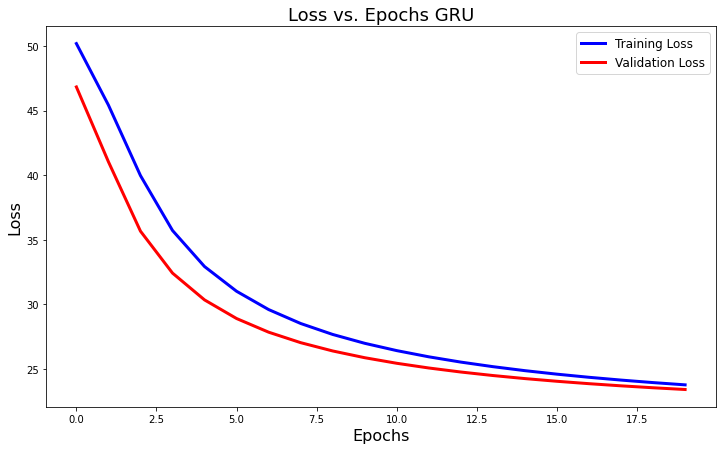

<Figure size 432x288 with 0 Axes>

In [63]:
plt.figure(figsize=(12, 7))
plt.plot(history_train_loss, 'b', linewidth=3.0, label='Training Loss')
plt.plot(history_val_loss, 'r', linewidth=3.0, label='Validation Loss')
plt.title('Loss vs. Epochs GRU', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()
# plt.savefig('results/LossvsEpochs.png')

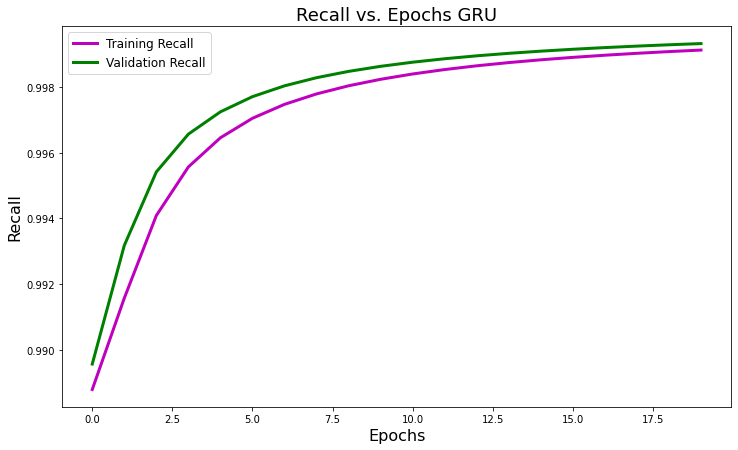

<Figure size 432x288 with 0 Axes>

In [62]:
plt.figure(figsize=(12, 7))
plt.plot(history_train_recall, 'm', linewidth=3.0, label='Training Recall')
plt.plot(history_val_recall, 'g', linewidth=3.0, label='Validation Recall')
plt.title('Recall vs. Epochs GRU', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.legend(fontsize=12)
plt.show()
# plt.savefig('results/RecallvsEpochs.png')

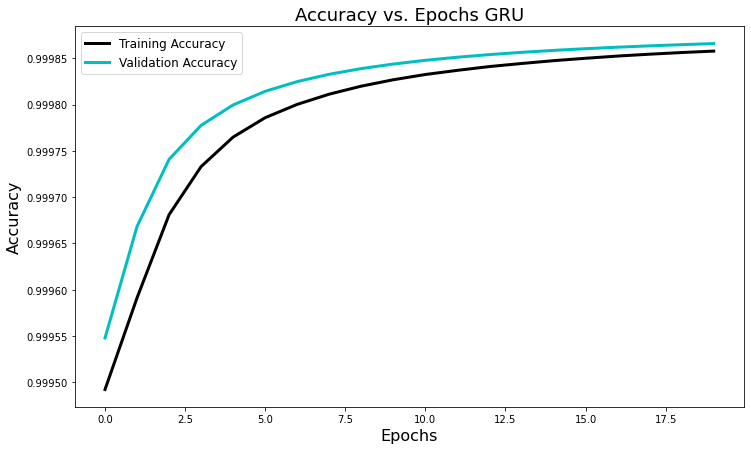

<Figure size 432x288 with 0 Axes>

In [48]:
plt.figure(figsize=(12, 7))
plt.plot(history_train_accuracy, 'k', linewidth=3.0, label='Training Accuracy')
plt.plot(history_val_accuracy, 'c', linewidth=3.0, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs GRU', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=12)
plt.show()
#plt.savefig('results/AccuracyvsEpochs.png')

## Evaluation

In [41]:
test_ds = Dataset(test[0], test[1])
test_samp = Sampler(test_ds, batch_size, shuffle=False)
test_dl = DataLoader(test_ds, sampler=test_samp, collate_fn=collate)

In [98]:
load_checkpoint(torch.load('trained.pth.tar'), model, optimizer)

=> Loading checkpoint


In [42]:
def test_(test_loader, model, optimizer): 
    history_test_recall = []
    history_test_precision = []
    history_test_accuracy = []
    history_test_f1 = []
    recall_test = []
    precision_test = []
    accuracy_test = []
    f1_test = []
                    
    start = time.time()
    model.eval()
    test_iteration = 0
    with torch.no_grad():                                       
        for X_batch, y_batch in test_loader:    # test
            X_batch, y_batch, mask_batch, lengths_batch = padding(X_batch, y_batch, 6984, 6984)
            X_batch = X_batch.to(DEVICE, dtype=torch.float)
            y_batch = y_batch.to(DEVICE, dtype=torch.long) 
            mask_batch = mask_batch.to(DEVICE, dtype=torch.float)
            lengths_batch = lengths_batch.to(DEVICE, dtype=torch.float)
            preds = model(X_batch, mask_batch)
            test_accuracy, test_recall, test_precision, test_f1_score = metrics(preds, y_batch).metrics()
            accuracy_test.append(test_accuracy)
            recall_test.append(test_recall)
            precision_test.append(test_precision)
            f1_test.append(test_f1_score)
            test_iteration+=1               
        test_acc = np.mean(accuracy_test)
        history_test_accuracy.append(test_acc)                     
        test_rec = np.mean(recall_test)                   
        history_val_recall.append(test_rec) 
        test_precision = np.mean(precision_test)                   
        history_test_precision.append(test_precision)
        test_f1 = np.mean(f1_test)                   
        history_test_f1.append(test_f1)       
                   
        print(f' test recall: {test_rec:.6f}, test precision: {test_precision:.6f}, test accuracy: {test_acc:.6f}, test f1: {test_f1:.6f}')
    end = time.time()
    print('Testing has taken ', end - start, 'seconds to complete')
    return history_test_recall, history_test_precision, history_test_accuracy, history_test_f1

In [43]:
history_test_recall, history_test_precision, history_test_accuracy, history_test_f1 = test_(test_dl, model, optimizer)

 test recall: 1.000000, test precision: 0.000000, test accuracy: 0.999885, test f1: 0.000000
Testing has taken  2.3381383419036865 seconds to complete
